<a href="https://colab.research.google.com/github/wliangxy/advertiser-quality-from-sites/blob/master/source/baseline_category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs
# import nltk
# from nltk.corpus import stopwords

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [2]:
os. getcwd()

'/home/wliang_google_com/Documents/workspace/notebook'

In [3]:
df = pd.read_csv(os.path.join('/home/vahidsanei_google_com/data/yelp_data/updated', 'bussiness_with_corpus.csv'))
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,...,0,0,0,0,1,0,0,0,True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,...,0,0,0,0,0,0,0,1,False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,...,0,0,0,0,0,0,1,0,True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,...,0,0,0,0,0,0,1,0,True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,...,0,0,0,0,0,0,0,1,True,Contact Junction Tire Tires Auto Repair Shop i...


In [4]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', 'is_eng',
       'webpage_corpus'],
      dtype='object')

In [5]:
df = df[df['categories'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55963 entries, 0 to 56064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      55963 non-null  int64  
 1   business_id     55963 non-null  object 
 2   name            55963 non-null  object 
 3   address         53592 non-null  object 
 4   city            55963 non-null  object 
 5   state           55963 non-null  object 
 6   postal_code     55854 non-null  object 
 7   latitude        55963 non-null  float64
 8   longitude       55963 non-null  float64
 9   stars           55963 non-null  float64
 10  review_count    55963 non-null  int64  
 11  is_open         55963 non-null  int64  
 12  attributes      48188 non-null  object 
 13  categories      55963 non-null  object 
 14  hours           45045 non-null  object 
 15  url             55963 non-null  object 
 16  webpage_text    50380 non-null  object 
 17  1.0             55963 non-null 

In [6]:
df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


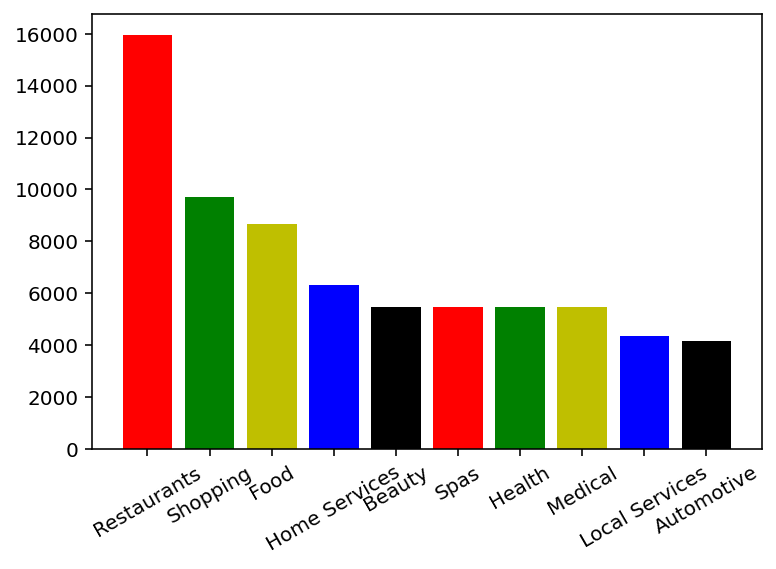

In [7]:
Categories={}

for x in df.categories:
    for cls in x:
        cls = cls.strip()
        if len(cls) < 2: continue
        if cls not in Categories: Categories[cls]=1
        else: Categories[cls]+=1

All_categories=list(Categories.keys())
classes=[[x,Categories[x]] for x in All_categories]
classes=sorted(classes, key=lambda x: x[1], reverse=True)
all_classes = classes
classes=classes[:10]
plt.bar(range(len(classes)),[x[1] for x in classes] ,align='center', color='rgybk')
plt.xticks(range(len(classes)), [x[0] for x in classes], rotation=30);

In [8]:
all_classes=sorted(all_classes, key=lambda x: x[1], reverse=True)

In [9]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'Health', 'Dentists': 'Health', 'Doctors': 'Health', 'Medical Centers': 'Health', 'Drugstores': 'Health',
                'Local Services': 'Health', 

                'Local Services': 'Local Services', 'Car Dealers': 'Local Services', 'Professional Services': 'Local Services', 
                'Home Services': 'Local Services','Garden': 'Local Services', 'Real Estate': 'Local Services',
                'Auto Repair': 'Local Services', 'Pet Services': 'Local Services', 'Home Cleaning': 'Local Services', 
                'Public Services': 'Local Services', 'Home Decor': 'Local Services', 
                'Automotive': 'Local Services', 'Pets': 'Local Services',
    
                'Hair Salons': 'Salons', 'Nail Salons': 'Salons', 'Beauty': 'Salons', 'Hair Salons': 'Salons', 'Makeup Artists': 'Salons',
                'Hair Removal': 'Salons', 'Massage': 'Salons', 'Barbers': 'Salons', 'Beauty Supply': 'Salons',
                
                'Entertainment': 'Entertainment', 'Event Planning': 'Entertainment', 'Golf': 'Entertainment',
                'Active Life': 'Entertainment', 'Nightlife': 'Entertainment',

                'Hotels': 'Travel', 'Travel': 'Travel',
    
                'Jewelry': 'Shopping', 'Shopping': 'Shopping', 'Hobby Shops': 'Shopping', 

                'Fitness': 'Fitness', 'Sporting Goods': 'Fitness', 'Gyms': 'Fitness', 'Sports Bars': 'Fitness', 
    
                'Churches': 'Religious','Religious Organizations': 'Religious',
    
                'Education': 'Education',
    
                'Banks': 'Financial Services', 'Financial Services': 'Financial Services',
    
                'Mass Media': 'Media'
        }

In [10]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'Health', 'Dentists': 'Health', 'Doctors': 'Health', 'Medical Centers': 'Health', 'Drugstores': 'Health',
                'Local Services': 'Health', 

                'Local Services': 'Local Services', 'Car Dealers': 'Local Services', 'Professional Services': 'Local Services', 
                'Home Services': 'Local Services','Garden': 'Local Services', 'Real Estate': 'Local Services',
                'Auto Repair': 'Local Services', 'Pet Services': 'Local Services', 'Home Cleaning': 'Local Services', 
                'Public Services': 'Local Services', 'Home Decor': 'Local Services', 
                'Automotive': 'Local Services', 'Pets': 'Local Services',
    
                'Hair Salons': 'Local Services', 'Nail Salons': 'Local Services', 'Beauty': 'Local Services', 'Hair Salons': 'Local Services', 'Makeup Artists': 'Local Services',
                'Hair Removal': 'Local Services', 'Massage': 'Local Services', 'Barbers': 'Local Services', 'Beauty Supply': 'Local Services',
                
                'Entertainment': 'Entertainment', 'Event Planning': 'Entertainment', 'Golf': 'Entertainment',
                'Active Life': 'Entertainment', 'Nightlife': 'Entertainment',

                'Hotels': 'Entertainment', 'Travel': 'Entertainment',
    
                'Jewelry': 'Entertainment', 'Shopping': 'Entertainment', 'Hobby Shops': 'Entertainment', 

                'Fitness': 'Entertainment', 'Sporting Goods': 'Entertainment', 'Gyms': 'Entertainment', 'Sports Bars': 'Entertainment', 
            
                'Banks': 'Financial Services', 'Financial Services': 'Financial Services',
    
                'Mass Media': 'Entertainment'
        }

In [11]:
cat = {}
bad = []
for x in df.categories:
    flg = False
    for cls in x:
        cls = cls.strip()
        if not cls in map_classes: continue
        flg = True
        mapped_cls = map_classes[cls]
        if mapped_cls not in cat: cat[mapped_cls]=1
        else: cat[mapped_cls]+=1
    if flg is False:
        bad.append(x)
        
print(len(bad))
bad[:100]

450


[['Churches', ' Religious Organizations'],
 ['Churches', ' Religious Organizations'],
 ['Driving Schools', ' Specialty Schools', ' Education'],
 ['Education', ' Preschools'],
 ['Preschools', ' Education'],
 ['Churches', ' Religious Organizations'],
 ['Preschools',
  ' Elementary Schools',
  ' Education',
  ' Middle Schools ',
  ' High Schools',
  ' Educational Services'],
 ['Education', ' Test Preparation'],
 ['Churches', ' Religious Organizations'],
 ['Religious Organizations'],
 ['Education',
  ' Colleges ',
  ' Universities',
  ' Specialty Schools',
  ' Adult Education',
  ' Vocational ',
  ' Technical School'],
 ['Preschools', ' Elementary Schools', ' Education'],
 ['Elementary Schools', ' Education'],
 ['Specialty Schools', ' Cosmetology Schools', ' Education'],
 ['Education', ' Middle Schools ', ' High Schools', ' Elementary Schools'],
 ['Education', ' Colleges ', ' Universities'],
 ['Religious Organizations', ' Churches'],
 ['Churches', ' Religious Organizations'],
 ['Religious 

In [12]:
classes_set = set(map_classes.values())
classes_set

{'Entertainment', 'Financial Services', 'Food', 'Health', 'Local Services'}

In [13]:
test = []
val = 0
for arr in df['categories']:
    test.append(None)
    for x in arr:
        cls = x.strip()
        if not cls in map_classes:
            continue
        val += 1
        test[-1] = map_classes[cls]
        break

In [14]:
df['categories'] = test
df = df[df['categories'].notnull()]

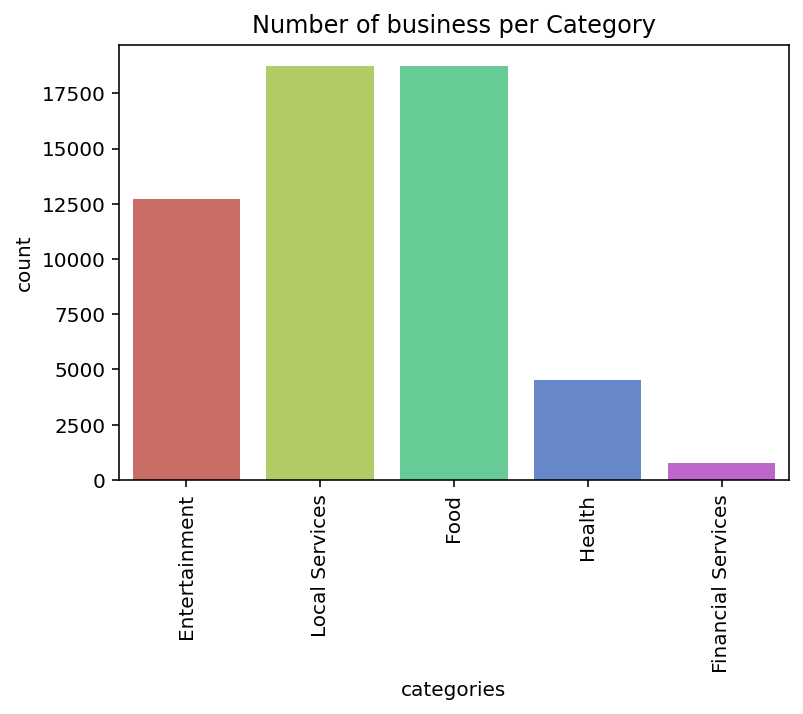

In [15]:
chart = sns.countplot(df['categories'], palette='hls')
plt.title('Number of business per Category')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center', rotation=90);

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55513 entries, 0 to 56064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      55513 non-null  int64  
 1   business_id     55513 non-null  object 
 2   name            55513 non-null  object 
 3   address         53149 non-null  object 
 4   city            55513 non-null  object 
 5   state           55513 non-null  object 
 6   postal_code     55405 non-null  object 
 7   latitude        55513 non-null  float64
 8   longitude       55513 non-null  float64
 9   stars           55513 non-null  float64
 10  review_count    55513 non-null  int64  
 11  is_open         55513 non-null  int64  
 12  attributes      48106 non-null  object 
 13  categories      55513 non-null  object 
 14  hours           44794 non-null  object 
 15  url             55513 non-null  object 
 16  webpage_text    49966 non-null  object 
 17  1.0             55513 non-null 

In [17]:
folder_path = os.path.join('/home/vahidsanei_google_com/data', 'uncased_L-12_H-768_A-12')

print (folder_path)
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12
['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [29]:
class categoryDetection:    
    def __init__(self, train, test, tokenizer: FullTokenizer, text_colname=None, label_colname=None, max_seq_len=128):
        """  
        """
        self.text_colname = 'webpage_corpus' if text_colname is None else text_colname
        if not self.text_colname in train.columns or not self.text_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the corpus.')
            return
        
        self.label_colname = 'categories' if label_colname is None else label_colname
        if not self.label_colname in train.columns or not self.label_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the labels.')
            return
        
        self.classes = train[self.label_colname].unique().tolist()
        self.classes.sort()
        
        train = train.dropna(subset=[self.text_colname])
        test = test.dropna(subset=[self.text_colname])
        
        self.max_seq_len = 512
        self.tokenizer = tokenizer
        (self.train_x, self.train_y), (self.test_x, self.test_y) = map(self._tokanize, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._cut_with_padding, [self.train_x, self.test_x])
    
    def build_model(self, bert_config_file, bert_ckpt_file, dropout=0.6):
        """
        """
        bert = self._load_bert(bert_config_file, bert_ckpt_file)
        input_ = keras.layers.Input(shape=(self.max_seq_len, ), dtype='int64', name="input_ids")
        x = bert(input_)
        #get the first embedding from the output of BERT
        x = keras.layers.Lambda(lambda seq: seq[:,0,:])(x)
        
        x = keras.layers.Dropout(dropout)(x)
        #x = keras.layers.Dense(300, activation='relu')(x)
        #x = keras.layers.Dense(300, activation='relu')(x)
        output_ = keras.layers.Dense(units=len(self.classes), activation='relu')(x)
        
        model = keras.Model(inputs=input_, outputs=output_)
        model.build(input_shape=(None, self.max_seq_len))
        
        load_stock_weights(bert, bert_ckpt_file)
        
        return model
    
    def _load_bert(self, bert_config_file, bert_ckpt_file):
        try:
            with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
                bert_config = StockBertConfig.from_json_string(gf.read())
                bert_params = map_stock_config_to_params(bert_config)
                bert_params.adapter_size = None
                bert = BertModelLayer.from_params(bert_params, name='bert')
                return bert
        except Exception as e:
            print(e)
    
    def _tokanize(self, df):
        """
        """
        X, y = [], []
        all_tokens = []
        for _, entry in tqdm(df.iterrows()):
            corpus, label = entry[self.text_colname], entry[self.label_colname]
            tokens = self.tokenizer.tokenize(corpus)
            tokens = self._clean_tokens(tokens)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            L = 0
            for x in tokens:
                if '#' in x: continue
                L += 1
            L -= 2
            if L <= 50:
            #    print(tokens)
                continue
            all_tokens.append(tokens)
            ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(ids))
            X.append(ids)
            y.append(self.classes.index(label))
            
        print('{}%'.format(len(X) / len(df) * 100.0))
        all_tokens = sorted(all_tokens, key=lambda x: len(x))
        print(all_tokens[:20])
        
        return np.asarray(X), np.asarray(y)
    
    
    def _clean_tokens(self, tokens):
        # STOPS = set(stopwords.words('english'))
        clean_tokens = []
        for token in tokens:
            if any(map(str.isdigit, token)): 
                continue
            clean_tokens.append(token)
        return clean_tokens
    def _cut_with_padding(self, ids):
        """
        """
        X = []
        CLS_id = self.tokenizer.convert_tokens_to_ids(['[CLS]'])
        SEP_id = self.tokenizer.convert_tokens_to_ids(['[SEP]'])
        for token_id in ids:
            # ignore tokens '[CLS]' and '[SEP]' for now
            arr = token_id[1:-1]
            sz = min(len(arr), self.max_seq_len - 2)
            arr = CLS_id + arr[:sz] + SEP_id
            # pad the remaining cells with zero
            arr = arr + [0] * (self.max_seq_len - len(arr))
            X.append(np.asarray(arr))
        return np.asarray(X)

In [42]:
def compile_model(cat:categoryDetection, model, validation_split=0.05, batch_size=16, n_epochs=50, shuffle=True):
    log_dir = "/home/wliang_google_com/Documents/workspace/notebook/.log/website_rating/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
    

    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
    print(model.summary())
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(
        x=cat.train_x,
        y=cat.train_y,
        validation_split=validation_split,
        batch_size=batch_size,
        shuffle=shuffle,
        verbose=1,
        epochs=n_epochs,
        callbacks=[tensorboard_callback],
    )

In [37]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [38]:
cat = categoryDetection(train, test, tokenizer, max_seq_len=256)

25809it [06:05, 70.57it/s] 


81.20810569956217%
[['[CLS]', 'newman', 'arms', 'vegas', 'home', 'about', 'newman', 'contact', 'products', 'used', 'guns', 'specials', 'coating', '##s', 'modifications', 'events', 'home', 'about', 'newman', 'contact', 'products', 'used', 'guns', 'specials', 'coating', '##s', 'modifications', 'events', 'home', 'click', 'here', 'click', 'here', 'click', 'here', 'click', 'here', 'click', 'here', 'location', 'north', 'boulder', 'highway', 'suite', 'a', 'henderson', 'nevada', 'follow', 'contact', 'us', 'powered', 'by', 'red', 'wing', 'solutions', '[SEP]'], ['[CLS]', 'page', 'not', 'found', 'page', 'not', 'found', 'sorry', 'for', 'the', 'inc', '##on', '##ven', '##ience', 'the', 'page', 'you', 'are', 'trying', 'to', 'view', 'is', 'not', 'at', 'this', 'link', 'the', 'page', 'location', 'may', 'have', 'changed', 'or', 'the', 'ur', '##l', 'may', 'be', 'entered', 'incorrectly', 'here', 'are', 'some', 'alternatives', 'to', 'locate', 'the', 'information', 'you', 'seek', 'home', 'page', 'contact', '

6436it [01:29, 72.01it/s]


80.73337476693598%
[['[CLS]', 'new', 'york', 'fries', 'accessible', 'customer', 'service', 'policy', 'privacy', 'policy', 'menu', 'our', 'food', 'loyalty', 'program', 'gift', 'cards', 'locations', 'international', 'locations', 'view', 'all', 'ny', '##f', 'locations', 'work', 'here', 'franchise', 'contact', 'contact', 'information', 'customer', 'service', 'work', 'here', 'franchise', 'information', 'promotions', 'facebook', 'twitter', 'ins', '##tagram', 'ny', '##f', 'location', 'south', 'centre', 'mall', 'open', 'anderson', 'road', 'se', 'calgary', 'alberta', 'canada', '[SEP]'], ['[CLS]', 'hard', 'rock', 'hotel', 'casino', 'in', 'las', 'vegas', 'is', 'closed', 'get', 'on', 'the', 'list', 'click', 'here', 'to', 'get', 'exciting', 'updates', 'on', 'our', 'transformation', 'guest', 'relations', 'call', 'or', 'email', 'email', 'protected', 'billing', 'questions', 'call', 'or', 'email', 'email', 'protected', 'for', 'events', 'meetings', 'conventions', 'click', 'here', 'for', 'all', 'other', 

In [39]:
len(cat.train_x)

20959

In [43]:
model = cat.build_model(bert_config_file, bert_ckpt_file)

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7d8f4b7090> (prefix:bert_4). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
compile_model(cat, model)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          108890112 
_________________________________________________________________
lambda_4 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 3845      
Total params: 108,893,957
Trainable params: 108,893,957
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
1245/1245 [==============================] - 561s 451ms/step - loss: 1.3840 - acc: 0.4084 - val

In [ ]:
model.evaluate(cat.test_x, cat.test_y)